<a href="https://colab.research.google.com/github/arvindsuresh-math/Fall-2025-Team-Big-Data/blob/main/Naive_Random_Forests_for_NEW_AirBNB_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

In [6]:
from fastbook import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
df_rs = pd.read_parquet('/content/gdrive/MyDrive/insideairbnb/nyc/nyc_final_modeling_dataset.parquet')
display(df_rs.head(1))

,listing_id,year_month,target_price,estimated_occupancy_rate,latitude,longitude,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,bathrooms_numeric,bathrooms_type,amenities,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews_ltm,host_is_superhost,host_response_rate,host_acceptance_rate,host_identity_verified,instant_bookable,month
0,32844072,2024-10,86.0,0.266667,40.76499,-73.87989,East Elmhurst,Entire rental unit,Entire home/apt,2,2.0,1.0,1.0,private,"[""Cleaning products"", ""Private entrance"", ""Dishes and silverware"", ""Shampoo"", ""Wifi"", ""Essentials"", ""Coffee maker"", ""Outdoor furniture"", ""Heating"", ""Pets allowed"", ""Long term stays allowed"", ""Refrigerator"", ""Carbon monoxide alarm"", ""Stove"", ""Private patio or balcony"", ""Keypad"", ""Hot water"", ""Microwave"", ""City skyline view"", ""Air conditioning"", ""Baking sheet"", ""Laundromat nearby"", ""Kitchen"", ""Dryer"", ""Portable fans"", ""Cooking basics"", ""Exterior security cameras on property"", ""Conditioner"", ""Body soap"", ""Self check-in"", ""Smoke alarm"", ""Luggage dropoff allowed"", ""Bed linens"", ""32 inch HDTV""]",4.72,4.82,4.77,4.82,4.63,4.71,1,False,0.79,0.81,True,False,10


In [9]:
dep_var = 'target_price'
cont_rs, cat_rs = cont_cat_split(df_rs, max_card=9000, dep_var=dep_var)

In [60]:
#
#
#
#
#

In [34]:
cont_loc = ['latitude', 'longitude']

In [35]:
cat_loc = ['neighbourhood_cleansed']

In [36]:
splits = RandomSplitter()(range_of(df_rs))

In [37]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [38]:
def rf(xs, y, n_estimators=40, max_samples=10000,max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs = -1, n_estimators=n_estimators, max_samples = max_samples, max_features = max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [39]:
def m_rmse(m, xs, y):
  return r_mse(m.predict(xs), y)

In [40]:
procs_rf = [Categorify, FillMissing]

In [41]:
to_loc = TabularPandas(df_rs, procs_rf, cat_loc, cont_loc, y_names=dep_var, splits=splits)

In [42]:
len(to_loc.train), len(to_loc.valid)

(66575, 16643)

In [44]:
xs_loc, y_loc = to_loc.train.xs, to_loc.train.y
valid_xs_loc, valid_y_loc = to_loc.valid.xs, to_loc.valid.y

In [62]:
m_loc = rf(xs_loc, y_loc)

In [63]:
m_rmse(m_loc, xs_loc, y_loc), m_rmse(m_loc, valid_xs_loc, valid_y_loc)

(776.572245, 800.878919)

In [64]:
preds_loc = np.stack([t.predict(valid_xs_loc) for t in m_loc.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [48]:
r_mse(preds_loc.mean(0), valid_y_loc)

802.08985

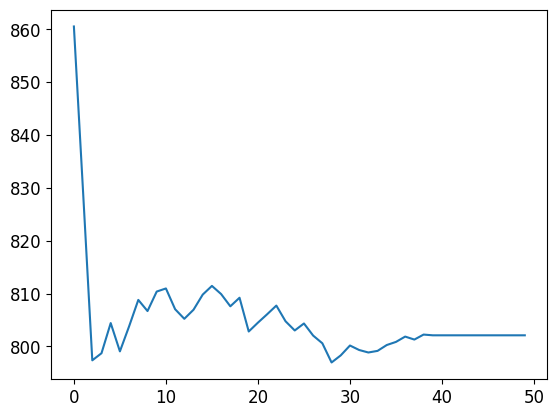

In [49]:
plt.plot([r_mse(preds_loc[:i+1].mean(0), valid_y_loc) for i in range(50)])

In [50]:
r_mse(m_loc.oob_prediction_, y_loc)

799.761182

In [51]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

In [52]:
fi = rf_feat_importance(m, xs_loc)
fi[:10]

,cols,imp
1,latitude,0.593372
2,longitude,0.354188
0,neighbourhood_cleansed,0.052440


In [53]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<Axes: ylabel='cols'>

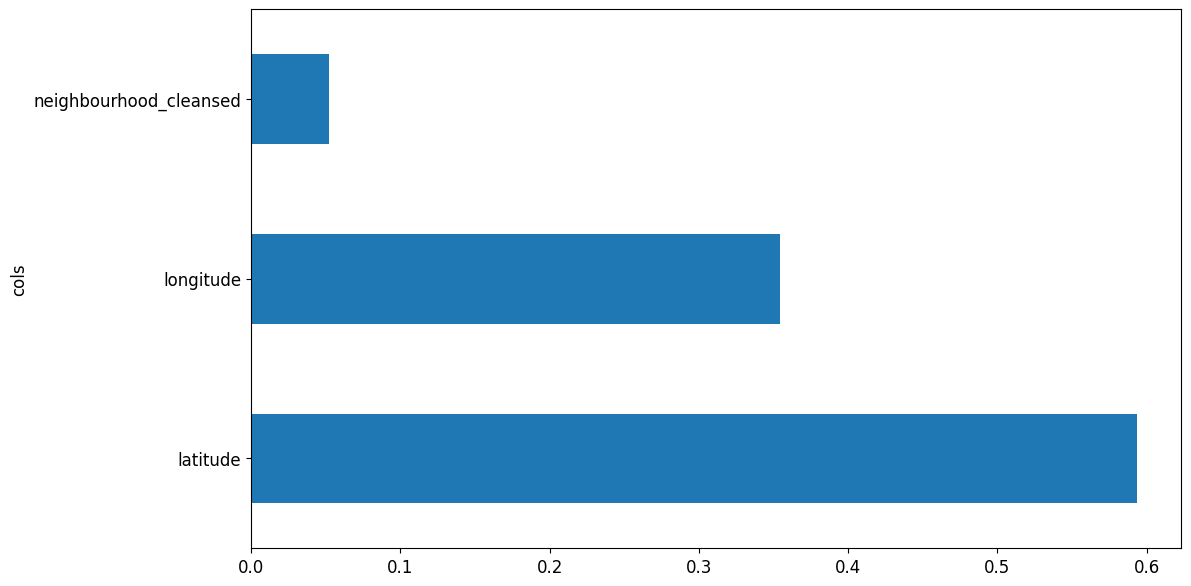

In [54]:
plot_fi(fi[:30])

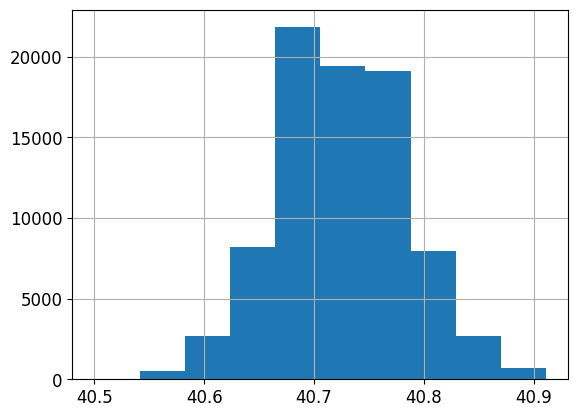

In [56]:
df_rs['latitude'].hist();

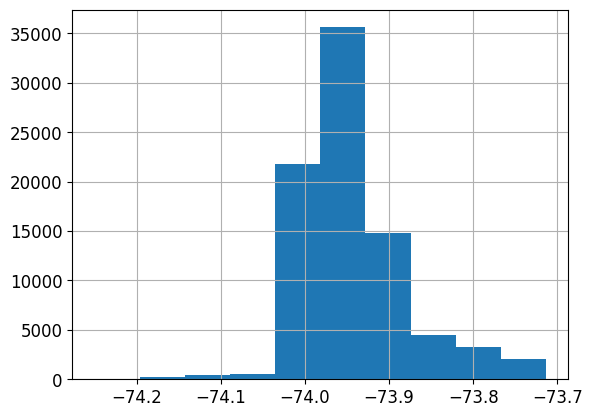

In [57]:
df_rs['longitude'].hist();

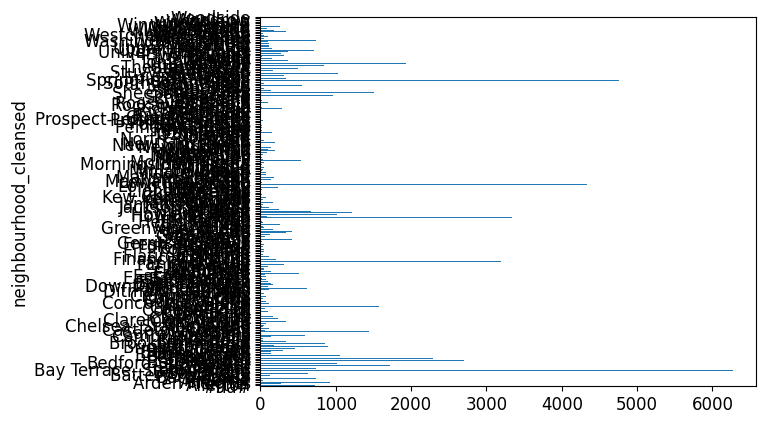

In [59]:
p = df_rs['neighbourhood_cleansed'].value_counts(sort=False).plot.barh()
c = to_loc.classes['neighbourhood_cleansed']
plt.yticks(range(len(c)), c);

In [61]:
#
#
#
#
#

In [66]:
cont_size = ['accommodates', 'bedrooms', 'bathrooms_numeric']
cat_size = ['property_type', 'room_type']
to_size = TabularPandas(df_rs, procs_rf, cat_size, cont_size, y_names=dep_var, splits=splits)
xs_size, y_size = to_size.train.xs, to_size.train.y
valid_xs_size, valid_y_size = to_size.valid.xs, to_size.valid.y

m_size = rf(xs_size, y_size)
preds_size = np.stack([t.predict(valid_xs_size) for t in m_size.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [67]:
r_mse(preds_size.mean(0), valid_y_size)

822.496516

In [68]:
r_mse(m_size.oob_prediction_, y_size)

800.377916

In [ ]:
#
#
#
#
#

In [78]:
cont_rep = ['review_scores_rating', 'number_of_reviews_ltm']
cat_rep = ['host_is_superhost']
to_rep  = TabularPandas(df_rs, procs_rf, cat_rep , cont_rep , y_names=dep_var, splits=splits)
xs_rep , y_rep  = to_rep.train.xs, to_rep.train.y
valid_xs_rep , valid_y_rep  = to_rep.valid.xs, to_rep.valid.y

m_rep  = rf(xs_rep , y_rep )
preds_rep  = np.stack([t.predict(valid_xs_rep ) for t in m_rep.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [79]:
r_mse(preds_rep.mean(0), valid_y_rep)

852.575954

In [80]:
r_mse(m_rep.oob_prediction_, y_rep)

831.473825

In [ ]:
#
#
#
#
#

In [81]:
cont_mon = ['month']
cat_mon = []
to_mon  = TabularPandas(df_rs, procs_rf, cat_mon , cont_mon , y_names=dep_var, splits=splits)
xs_mon , y_mon  = to_mon.train.xs, to_mon.train.y
valid_xs_mon , valid_y_mon  = to_mon.valid.xs, to_mon.valid.y

m_mon  = rf(xs_mon , y_mon )
preds_mon  = np.stack([t.predict(valid_xs_mon ) for t in m_mon.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [82]:
r_mse(preds_mon.mean(0), valid_y_mon)

860.663032

In [83]:
r_mse(m_mon.oob_prediction_, y_mon)

829.68992

In [ ]:
#
#
#
#
#